In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta

In [20]:
#Preparar el dataset, hacer merge de varios csv correspondientes a meses abril a septiembre
def prepare_df():
    
    uber_2014_apr=pd.read_csv('input/uber-raw-data-apr14.csv',header=0)
    uber_2014_may=pd.read_csv('input/uber-raw-data-may14.csv',header=0)
    uber_2014_jun=pd.read_csv('input/uber-raw-data-jun14.csv',header=0)
    uber_2014_jul=pd.read_csv('input/uber-raw-data-jul14.csv',header=0)
    uber_2014_aug=pd.read_csv('input/uber-raw-data-aug14.csv',header=0)
    uber_2014_sep=pd.read_csv('input/uber-raw-data-sep14.csv',header=0)

    
    #Merging
    df = uber_2014_apr.append([uber_2014_may,uber_2014_jun,uber_2014_jul,uber_2014_aug,uber_2014_sep], ignore_index=True)
    
    return df

uber_2014 = prepare_df()
uber_2014.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [21]:
# Feature Engineering
def create_day_series(df):
    
    # Agrupar por  Date/Time para calcular el numero de viajes
    day_df = pd.Series(df.groupby(['Date/Time']).size())
    # Establecer Date/Time como indice
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling/Remuestreo a viajes diarios, se realiza la suma de los viajes en otra unidad de sampling
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

day_df_2014 = create_day_series(uber_2014)
day_df_2014.head()

Date/Time
2014-04-01    14546
2014-04-02    17474
2014-04-03    20701
2014-04-04    26714
2014-04-05    19521
Freq: D, dtype: int64

p-value: 0.8458980824898368


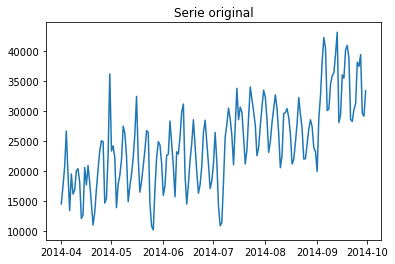

<Figure size 432x288 with 0 Axes>

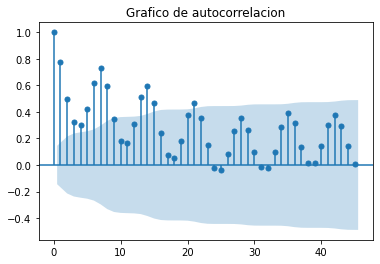

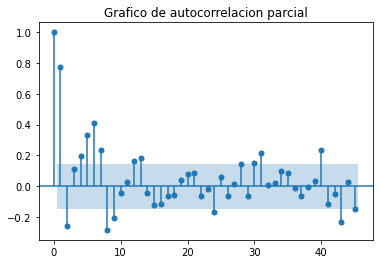

In [17]:
#Chequear tendencia y autocorrelacion
def initial_plots(time_series, num_lag):

    #Plot. de la serie original
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Serie original')
    plt.figure(2)
    plot_acf(time_series, lags = num_lag)
    plt.title('Grafico de autocorrelacion')
    plot_pacf(time_series, lags = num_lag)
    plt.title('Grafico de autocorrelacion parcial')
    
    plt.show()

    
#Prueba Augmented Dickey-Fuller para comprobar estacionaridad/ datos estacionarios
# la media y la varianza de una serie estacionaria no cambian con el tiempo
#p-value, indicador de ADF de estacionaridad
print('p-value: {}'.format(adfuller(day_df_2014)[1]))

#plotting
initial_plots(day_df_2014, 45)

In [22]:
#almacenar series diferenciadas
diff_series = day_df_2014.diff(periods=1)

#prueba Augmented Dickey-Fuller para comprobar estacionaridad
#p-value
print('p-value: {}'.format(adfuller(diff_series.dropna())[1]))

p-value: 1.5163641177434954e-08


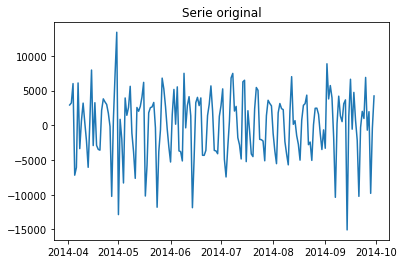

<Figure size 432x288 with 0 Axes>

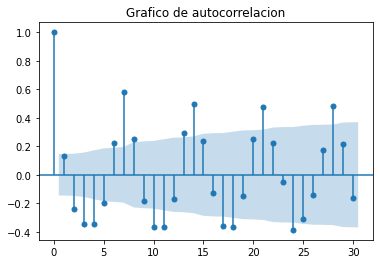

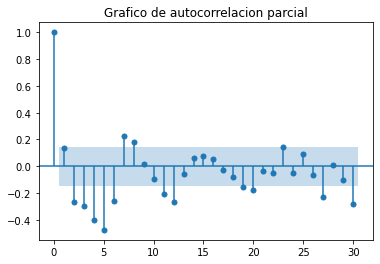

In [23]:
initial_plots(diff_series.dropna(), 30)

In [12]:
#Root mean square error
def rmse(x,y):
    return sqrt(mean_squared_error(x,y))

#entrenar modelo ARIMA en el dataset
def SARIMAX_call(time_series,p_list,d_list,q_list,P_list,D_list,Q_list,s_list,test_period):    
    
    #Dividir en training y testing datasets
    training_ts = time_series[:-test_period]
    
    testing_ts = time_series[len(time_series)-test_period:]
    
    error_table = pd.DataFrame(columns = ['p','d','q','P','D','Q','s','RMSE'],\
                                                           index = range(len(ns_ar)*len(ns_diff)*len(ns_ma)*len(s_ar)\
                                                                         *len(s_diff)*len(s_ma)*len(s_list)))
    count = 0
    
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            for s in s_list:
                                #fitting the model
                                SARIMAX_model = SARIMAX(training_ts.astype(float),\
                                                        order=(p,d,q),\
                                                        seasonal_order=(P,D,Q,s),\
                                                        enforce_invertibility=False)
                                SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
                                predictions = SARIMAX_model_fit.forecast(steps=test_period,typ='levels')
                                RMSE = rmse(testing_ts.values,predictions.values)                                

                                #populating error table
                                error_table['p'][count] = p
                                error_table['d'][count] = d
                                error_table['q'][count] = q
                                error_table['P'][count] = P
                                error_table['D'][count] = D
                                error_table['Q'][count] = Q
                                error_table['s'][count] = s
                                error_table['RMSE'][count] = RMSE
                                
                                count+=1 #incrementing count        
    
    return error_table

ns_ar = [0,1,2]
ns_diff = [1]
ns_ma = [0,1,2]
s_ar = [0,1]
s_diff = [0,1] 
s_ma = [1,2]
s_list = [7]

error_table = SARIMAX_call(day_df_2014,ns_ar,ns_diff,ns_ma,s_ar,s_diff,s_ma,s_list,30)

/Users/sebastiancattaneo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sebastiancattaneo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sebastiancattaneo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sebastiancattaneo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

In [13]:
# de error_table se imprimen los que tengan menor RMSE
error_table.sort_values(by='RMSE').head(5)

p  d  q  P  D  Q  s         RMSE
5  0  1  0  1  0  2  7  5042.179287
3  0  1  0  0  1  2  7  5105.300737
7  0  1  0  1  1  2  7   5136.56535
6  0  1  0  1  1  1  7  5278.110602
2  0  1  0  0  1  1  7  5336.341983

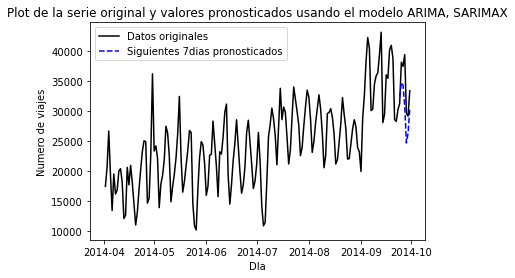

Prediction
2014-09-24  32408.595764
2014-09-25  34813.502670
2014-09-26  34404.677408
2014-09-27  30916.684527
2014-09-28  24721.941496
2014-09-29  26327.428628
2014-09-30  30377.894507

In [24]:
#Generacion de modelo con parametros hallados previamente y predicción
def predict(time_series,p,d,q,P,D,Q,s,n_days,conf):
    
    #Dividir en training y testing datasets
    training_ts = time_series[:-n_days]
    
    testing_ts = time_series[len(time_series)-n_days:]
    
    #fit/training del modelo
    SARIMAX_model = SARIMAX(training_ts.astype(float),\
                            order=(p,d,q),\
                            seasonal_order=(P,D,Q,s),\
                            enforce_invertibility=False)
    SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
    
    #Predicción
    SARIMAX_prediction = pd.DataFrame(SARIMAX_model_fit.forecast(steps=n_days,alpha=(1-conf)).values,\
                          columns=['Prediction'])
    SARIMAX_prediction.index = pd.date_range(training_ts.index.max()+timedelta(days=1),periods=n_days)
    
    
    plt.figure(4)
    plt.title('Plot de la serie original y valores pronosticados usando el modelo ARIMA, SARIMAX')
    plt.xlabel('DIa')
    plt.ylabel('Numero de viajes')
    plt.plot(time_series[1:],'k-', label='Datos originales')
    plt.plot(SARIMAX_prediction,'b--', label='Siguientes {}dias pronosticados'.format(n_days))
    plt.legend()
    plt.show()
    
    
    return SARIMAX_prediction

#Se intenta predecir con un intervalo de confianza del 80%
prediction = predict(day_df_2014,0,1,0,0,1,2,7,7,0.80)

prediction